In [1]:
# finetuning llama2

# (Q)分子構造+(R)理由+(A)物性データセットのLLMによる学習と予測
- Q&A: 融点データセットを使用
- R: GPT4を使い､Q&Aをもとに自動生成

In [2]:
#!pip install transformers==4.35.0
#!pip install peft==0.5.0
#!pip install bitsandbytes==0.41.1
#!pip install accelerate==0.23.0
#!pip install flash-attn==2.3.1.post1
#!pip install datasets==2.14.5

In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

from transformers import AutoModelForCausalLM, BitsAndBytesConfig
import torch
from peft import LoraConfig, get_peft_model
from transformers import AutoTokenizer,pipeline
from datasets import Dataset
import copy
from tqdm import tqdm
#問題設定: はじめのN件をテストデータにする
n_test=50

In [ ]:
#ハイパラ関連
#モデル名
model_size=7
model_size=13
#model_size=70
model_name=f"meta-llama/Llama-2-{model_size}b-chat-hf"

#LoRA関連
r=32
lora_alpha=32
bit=16
#bit=4

#LoRAのadapter
target_modules= [
    #"embed_tokens",
    "lm_head",
    #"q_proj",
    #"k_proj",
    "v_proj",
    "o_proj",
    "gate_proj",
    "up_proj",
    #"down_proj",
]

#学習関連
gradient_checkpointing = False
per_device_train_batch_size=1
epochs=2
lr=10**-5
do_train=True
#do_train=False

In [ ]:

device_map="auto"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

def init_model(model_name, r, lora_alpha, target_modules, bit=4):
    if bit == 4:
        print("Using 4-bit mode")
        model = AutoModelForCausalLM.from_pretrained(model_name,
                                                     quantization_config=bnb_config,
                                                     device_map=device_map,
                                                     use_flash_attention_2=True,
                                                     )
    elif bit == 16:
        print("Using fp16 mode")
        model = AutoModelForCausalLM.from_pretrained(model_name,
                                                     device_map=device_map,
                                                     torch_dtype=torch.float16,
                                                     use_flash_attention_2=True,
                                                     )
    else:
        raise ValueError("bit must be 4 or 16")

    if len(target_modules)==0:
        return model
    peft_config = LoraConfig(
        task_type="CAUSAL_LM", inference_mode=False, r=r, lora_alpha=lora_alpha,
        lora_dropout=0.1,
        target_modules=target_modules,
    )
    model = get_peft_model(model, peft_config)
    return model


In [5]:

#モデル初期化
model=init_model(model_name, r, lora_alpha, target_modules, bit=bit)

tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

#pipe = pipeline("text-generation", model=model,
#                tokenizer=tokenizer, max_new_tokens=1000)

Using fp16 mode


Loading checkpoint shards: 100%|██████████| 3/3 [00:04<00:00,  1.41s/it]


# データセットの生成

In [6]:
#データセットの読み込み
import pandas as pd
import random
df=pd.read_csv("dataset/231225AutoReasoning/240104best_reason_record.csv")
dataset=df.to_dict(orient="records")
random.seed(0)
random.shuffle(dataset)

print(df.shape)
df[:2]

(2406, 9)


,name,smiles,csid,link,source,Reason,mpC,Prediction(integer),Abs error
0,"2,3-dibromo-2-methyl-butane",BrC(C)(C)C(Br)C,71392,http://www.srcinc.com/what-we-do/product.aspx?...,PHYSPROP,"Starting with butane, which melts around -138....",7.0,6.6,0.4
1,5-chlorobenzofuroxan,c1cc2c(cc1Cl)no[n+]2[O-],123661,http://www.alfa.com/en/GP100W.pgm?DSSTK=A14261,Alfa Aesar,"The basic structure for comparison is benzene,...",47.0,45.0,2.0


In [7]:
import random
system_prompt="You are a professional chemist. Predict the melting point of the following compound."


def gen_compound_text(chemical_record,
    reason="",prediction=""):
    name=chemical_record["name"]
    smiles=chemical_record["smiles"]
    prompt=f"""
#Problem
##Name: {name}
##SMILES: {smiles}"""
    if reason !="" and prediction!="":
        prompt+=f"""
##Reason: {reason}
##Prediction: {prediction}
"""
    else:
        #test mode
        prompt+="""
##Reason: 
"""
    return prompt



def generate_question_prompt(dataset,test_id,n_prompt_examples=5):
    train_ids=[i for i in range(len(dataset))]
    train_ids.remove(test_id)
    prompt=""

    #train prompt
    for _ in range(n_prompt_examples):
        id=random.choice(train_ids)
        prompt+=gen_compound_text(dataset[id],
                                reason=dataset[id]["Reason"],
                                prediction=dataset[id]["Prediction(integer)"])
        prompt+="\n"

    #test prompt
    prompt+=gen_compound_text(dataset[test_id])

    return prompt


def prepare_dataset(context_list, tokenizer):
    data_list = [{"text": i} for i in context_list]
    random.shuffle(data_list)

    # tokenize
    dataset = Dataset.from_dict(
        {"text": [item["text"] for item in data_list[:]]})
    dataset = dataset.map(lambda samples: tokenizer(
        samples['text']), batched=True)

    return dataset


In [9]:


train_text_list=[]
for id in range(len(dataset)):
    prompt=gen_compound_text(dataset[id],
                                reason=dataset[id]["Reason"],
                                prediction=dataset[id]["Prediction(integer)"])
    train_text_list.append(prompt)
tokenized_dataset = prepare_dataset(train_text_list[n_test:], tokenizer)

Map:   0%|          | 0/2356 [00:00<?, ? examples/s]

Map: 100%|██████████| 2356/2356 [00:00<00:00, 8758.05 examples/s]


In [10]:
#check prompt

print("train")
print(prompt)
print("test")
t_prompt=gen_compound_text(dataset[0])
print(t_prompt)

train

#Problem
##Name: 2-Ethoxy-2-methylpropane
##SMILES: CC(C)(C)OCC
##Reason: The target compound, 2-Ethoxy-2-methylpropane, can be seen as derived from propane, which has a melting point of -187.7°C. Adding a methyl group generally increases the melting point due to increased molecular weight and van der Waals forces. For propane, adding a methyl group to become isobutane elevates the melting point to -159.6°C, indicating the effect of a methyl group is an increase of roughly +28°C. The presence of an ethoxy group (-OCC2H5) introduces an oxygen atom which can lead to dipole-dipole interactions and potential hydrogen bonding with trace moisture, increasing the melting point as well. The ethoxy group's effect on the melting point would be less straightforward to quantify without empirical data, but we can predict that it will raise the melting point to some extent. Considering the combined effect of an additional methyl group and an ethoxy group on the basic structure of propane, we 

# モデルの訓練

In [11]:
import transformers
from datetime import datetime


#train
train_args = transformers.TrainingArguments(
        per_device_train_batch_size=per_device_train_batch_size,
        #gradient_accumulation_steps=1,
        warmup_steps=0,
        num_train_epochs=epochs,
        learning_rate=lr,
        fp16=True,
        logging_steps=100,
        save_total_limit=1,
        output_dir='outputs/'+datetime.now().strftime('%Y%m%d%H%M%S'),
        gradient_checkpointing=gradient_checkpointing,
    )

# trainer
#callbacks = [EarlyStoppingCallback()]
callbacks = []

trainer = transformers.Trainer(
    model=model,
    train_dataset=tokenized_dataset,
    args=train_args,
    callbacks=callbacks,
    data_collator=transformers.DataCollatorForLanguageModeling(
        tokenizer, mlm=False)
)

if do_train:
    training_result = trainer.train()
    training_result.training_loss

You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss
100,1.691600
200,1.269800
300,1.161100
400,1.092600
500,1.091300
600,1.057100
700,1.029000
800,1.042600
900,1.031000
1000,1.015700


# モデルによる物性値の予測

In [ ]:

import re
import torch
import gc
from IPython.display import clear_output
model.eval()
def gen_text_stop_word(prompt,model,tokenizer,
                       device="cuda:0",
                       stop_words=["#Problem","#Reason"],
                       double_stop_words=["#Prediction"],
                       stream=False,
                       max_tokens=300):
    gc.collect()
    torch.cuda.empty_cache()

    input_ids = tokenizer.encode(prompt, return_tensors='pt').to(device)

    # 生成されたテキストを格納する変数
    generated_text = ""

    # トークンを一つずつ生成
    for i in range(max_tokens):
        # 次のトークンを予測
        outputs = model(input_ids)
        next_token_logits = outputs.logits[:, -1, :]
        next_token = torch.argmax(next_token_logits, dim=-1).unsqueeze(-1)

        # 生成されたトークンを現在の入力に追加
        input_ids = torch.cat([input_ids, next_token], dim=-1)

        # 生成されたテキストを更新
        generated_text = tokenizer.decode(input_ids[0], skip_special_tokens=True)[len(prompt):]

        if stream:
            if i%30==0:
                clear_output()
            print(generated_text)

        # ストップワードのチェック
        if any(stop_word in generated_text for stop_word in stop_words):
            break

        # 2回以上出現したらstopするwordのcheck 
        stop_flag=False
        for check_word in double_stop_words:
            count=generated_text.count(check_word)
            if count>=2:
                stop_flag=True
                break
        if stop_flag:
            break

    return generated_text

def ask_value(prompt,model,tokenizer):
    res=gen_text_stop_word(prompt,model,tokenizer)
    #res=pipe(prompt)[0]["generated_text"]
    print("----")
    print(res)

    regex_list=[
        r"Prediction:\s*(\d+\.?\d*)",
        r"Predicted melting point:\s*(\d+\.?\d*)",
    ]

    value=None
    for reg in regex_list:
        match = re.search(reg, res)
        if match:
            value = match.group(1)
            break
    return res,value



In [ ]:

random.seed(0)
prediction_results={}

#予測時のハイパラ
n_prompt_examples=3 #何件の例題をprompt tuningで出すか
n_max_trials=3  # 値を返さなかったときの再試行の最大数

res_list=[]
for test_id in tqdm(range(n_test)):
    print(f"promlem {test_id+1} / {n_test}")
    for _ in range(n_max_trials):
        try:
            prompt=generate_question_prompt(dataset,test_id,n_prompt_examples=n_prompt_examples)
            reason,value=ask_value(prompt,model,tokenizer)
        except Exception as e:
            print(e)
            continue


        if value is not None:
            record=copy.deepcopy(dataset[test_id])
            record["Test (Predicted reason)"]=reason
            record["Test (Predicted value)"]=value
            res_list.append(record)
            print("actual: ",record["mpC"],"predicted: ", record["Test (Predicted value)"],)
            break
prediction_results[n_prompt_examples]=res_list

  0%|          | 0/100 [00:00<?, ?it/s]

promlem 1 / 100


  1%|          | 1/100 [00:03<06:14,  3.78s/it]

----
##Prediction: 105.0


#Problem
actual:  74.0 predicted:  105.0
promlem 2 / 100


  2%|▏         | 2/100 [00:28<26:15, 16.08s/it]

----
- Basic unit, quinoxaline, has a melting point of around 100 degrees Celsius. 
- Chlorine atoms are electron-withdrawing groups that can increase the melting point due to their ability to form intermolecular dipole-dipole interactions. Each chlorine could add approximately +20 degrees Celsius. 
##Prediction: 120.0


#Problem
actual:  152.0 predicted:  120.0
promlem 3 / 100


  3%|▎         | 3/100 [00:49<29:52, 18.48s/it]

----
- Basic unit benzene has a melting point of 5.5°C.
- Chloromethyl groups: Each chloromethyl group is expected to increase the melting point due to the increase in molecular weight and the introduction of polarizability, which can enhance intermolecular forces. The effect of each chloromethyl group can be estimated at +20°C.
##Prediction: 105.0


#Problem
actual:  100.0 predicted:  105.0
promlem 4 / 100


  4%|▍         | 4/100 [01:18<35:57, 22.48s/it]

----
- Basic unit, benzene, has a melting point of 5.5 degrees Celsius. 
- The presence of two phenyl groups increases the melting point due to increased molecular weight and pi-pi stacking interactions, estimated at +100 degrees Celsius for each phenyl group. 
- The propenone (alkenone) group introduces rigidity and polarity, which can further increase the melting point, estimated at +50 degrees Celsius. 
- The overall structure is complex and rigid, which can lead to a higher melting point due to increased molecular interactions, estimated at +20 degrees Celsius. 
##Prediction: 225.0


#Problem
actual:  56.5 predicted:  225.0
promlem 5 / 100
----
##Prediction: -105.0


#Problem


  5%|▌         | 5/100 [02:14<54:53, 34.67s/it]

----
- Base structure (benzene): Benzene has a melting point of 5.5°C. 
- Hydroxyethyl group (OHCH2CH2): The hydroxyl group can form hydrogen bonds, which generally increases the melting point. The ethylene linker might slightly increase the melting point due to increased molecular weight and van der Waals interactions (+5°C). 
- Disulfide group (S-S): The disulfide bond is a strong dipole-dipole interaction that can significantly increase the melting point (+40°C). 
The actual value of 20.0°C suggests that the estimated contributions of the functional groups are not accurate. The hydroxyethyl group's effect on the melting point is less pronounced than expected, and the disulfide group's contribution is not as high as predicted.
##Prediction: 20.0


#Problem
actual:  26.0 predicted:  20.0
promlem 6 / 100


  6%|▌         | 6/100 [02:49<54:13, 34.62s/it]

----
- Basic unit, benzene, has a melting point of 5.5 °C.
- The presence of two phenyl groups increases the melting point due to increased molecular weight and pi-pi stacking interactions, estimated at +100 °C for each phenyl group.
- The nicotinamide group is a large, rigid structure that can form strong hydrogen bonds and has a significant impact on the melting point, estimated at +150 °C.
- The ethylene linker between the phenyl groups may slightly reduce the melting point due to less efficient packing, estimated at -5 °C.
##Prediction: 250.0


#Problem
actual:  159.0 predicted:  250.0
promlem 7 / 100


  7%|▋         | 7/100 [03:34<58:52, 37.99s/it]

----
- Basic unit, benzene, has a melting point of 5.5 °C. 
- Each methoxy group (–OCH3) is an electron-donating group that can increase the melting point due to increased molecular weight and dipole-dipole interactions, estimated at +10 °C per group. 
- The ketone group (–C=O) can form dipole-dipole interactions and increase the melting point, estimated at +20 °C. 
- The presence of two phenyl rings increases the melting point due to increased molecular weight and van der Waals interactions, estimated at +20 °C per ring. 
- The overall molecular structure is complex and rigid, which can further increase the melting point, estimated at +10 °C. 
##Prediction: 75.0


#Problem
actual:  109.0 predicted:  75.0
promlem 8 / 100


  8%|▊         | 8/100 [03:50<47:37, 31.06s/it]

----
- Basic unit, benzene, has a melting point of 5.5 °C.
- Propyl group: The addition of a propyl group to benzene generally increases the melting point due to an increase in molecular weight and van der Waals forces. This effect can be estimated to be around +20 °C.
##Prediction: 25.5


#Problem
actual:  -99.0 predicted:  25.5
promlem 9 / 100


  9%|▉         | 9/100 [03:54<34:21, 22.65s/it]

----
##Prediction: 105.0


#Problem
actual:  93.0 predicted:  105.0
promlem 10 / 100


 10%|█         | 10/100 [03:58<25:31, 17.02s/it]

----
##Prediction: 45.0


#Problem
actual:  -92.0 predicted:  45.0
promlem 11 / 100


 11%|█         | 11/100 [04:34<33:30, 22.59s/it]

----
- Basic unit, anisole, has a melting point of 20°C.
- Iodine atom: +40°C due to increased molecular weight and van der Waals forces.
- Nitro group: +50°C due to strong electron-withdrawing nature and potential for intermolecular hydrogen bonding.
- Anisole base structure: +20°C for the additional ring and potential for hydrogen bonding.

Adding these adjustments to the base value, we get: 20 + 40 + 50 + 20 = 130°C
##Prediction: 130.0


#Problem
actual:  97.0 predicted:  130.0
promlem 12 / 100


 12%|█▏        | 12/100 [04:37<24:45, 16.88s/it]

----
##Prediction: 10.0


#Problem
actual:  -137.4 predicted:  10.0
promlem 13 / 100


 13%|█▎        | 13/100 [05:28<39:06, 26.97s/it]

----
- Basic unit: Benzene has a melting point of 5.5°C.
- Bicyclo[4.2.0]octa-1,3,5-trien-7-ylidene group: This rigid, bicyclic structure increases the melting point due to increased molecular rigidity and potential for intermolecular interactions. Estimated increase: +100°C.
- 2-(2,4-dinitrophenyl)hydrazine group: The presence of two nitro groups and a hydrazine group significantly increases the melting point due to the strong electron-withdrawing nature of the nitro groups and the potential for intermolecular hydrogen bonding. Estimated increase: +150°C.
The combined effect of these groups should be additive.
##Prediction: 255.5


#Problem
actual:  203.0 predicted:  255.5
promlem 14 / 100


 14%|█▍        | 14/100 [07:04<1:08:50, 48.03s/it]

----
- Basic unit, indole, has a melting point of around 52°C. 
- Acetyl group: +5, due to increased molecular weight and potential for dipole-dipole interactions. 
- Nitro group: +40, due to strong electron-withdrawing nature and potential for intermolecular hydrogen bonding. 
- Phenyl group: +20, due to increased molecular weight and π-π stacking interactions. 
- Ethyl carbonate group: +5, due to increased molecular weight and potential for dipole-dipole interactions. 
Combining these effects, we estimate the melting point to be 52 (indole) + 5 (acetyl) + 40 (nitro) + 20 (phenyl) + 5 (ethyl carbonate) = 117. 
However, the actual value is 140.5, indicating that the effects of the functional groups may have been underestimated. The nitro group's contribution to the melting point is likely higher than initially predicted, and the cumulative effect of the multiple functional groups may have a synergistic effect that raises the melting point more than the sum of their individual contribut

 15%|█▌        | 15/100 [08:03<1:12:27, 51.15s/it]

----
- Base structure: Octane has a melting point of -57.2°C. 
- Methyl groups: Each methyl group can be expected to increase the melting point due to an increase in van der Waals forces. However, the steric hindrance of the methyl groups on the octane ring can disrupt the crystal lattice, potentially lowering the melting point. For this molecule, the steric hindrance appears to have a greater effect than the incremental increases from the methyl groups, thus resulting in a decreased melting point. We'll estimate a decrease of -5°C for each methyl group, for a total of -10°C for the two present. 
- The overall effect of the two methyl groups is a decrease in the melting point due to steric hindrance. 
##Prediction: -67.0


#Problem
promlem 16 / 100


 16%|█▌        | 16/100 [09:29<1:26:15, 61.62s/it]

----
The basic unit for comparison is benzene, which has a melting point of 5.5°C. The target compound, 4-phenoxybenzaldehyde, has several functional groups that will affect its melting point. The phenoxy group (–O–) is an electron-donating group that can increase the melting point due to increased molecular weight and possible dipole-dipole interactions; this effect is estimated to be +20°C. The aldehyde group (–CHO) can form hydrogen bonds, which typically increases the melting point; this effect is estimated to be +15°C. The combined effect of these groups is +35°C. However, the presence of the aldehyde group also introduces some degree of polarity, which can lead to stronger intermolecular forces, potentially increasing the melting point further. This effect is estimated to be an additional +5°C. The overall predicted increase is 5.5 (base for benzene) + 35 (phenoxy and aldehyde groups) + 5 (aldehyde group's additional polarity) = 45.5°C.
##Prediction: 45.0


#Problem
actual:  25.0

 17%|█▋        | 17/100 [10:19<1:20:31, 58.21s/it]

----
- Benzofuran base structure: +50 (due to the presence of two aromatic rings and a heterocycle, which increases the melting point significantly) 
- Chloro substituent: +20 (chlorine adds molecular weight and polarity, increasing intermolecular interactions) 
- Methylfuran substituent: +15 (the methyl group increases the melting point slightly due to increased molecular weight and van der Waals interactions) 
- Oxime group: +30 (the presence of the oxime group contributes to hydrogen bonding and dipole-dipole interactions, significantly raising the melting point) 
- Alkoxy group: +5 (the presence of an alkoxy group adds some polarity and can increase the melting point) 
Combining these effects gives a predicted melting point.
##Prediction: 120.0


#Problem
actual:  115.0 predicted:  120.0
promlem 18 / 100
----
##Prediction: -167.0


#Problem
----
- Basic unit: Ethylene (C2H4) has a melting point of -169.2°C.
- Double bond: The presence of a double bond in 1,2-propadiene increases th

 18%|█▊        | 18/100 [11:00<1:12:24, 52.98s/it]

----
##Prediction: -180.0


#Problem
promlem 19 / 100


 19%|█▉        | 19/100 [11:03<51:26, 38.10s/it]  

----
##Prediction: 100.0


#Problem
actual:  56.0 predicted:  100.0
promlem 20 / 100


 20%|██        | 20/100 [11:41<50:40, 38.00s/it]

----
The basic unit for comparison is pyridine, which has a melting point of -42°C. The amino group (–NH2) is capable of hydrogen bonding, which can significantly increase the melting point; we can estimate this increase to be around 80°C. Each fluorine atom (–F) is highly electronegative and can participate in dipole-dipole interactions, which can also increase the melting point; we can estimate this increase to be around 20°C for each fluorine atom, given there are four fluorine atoms, this would be 80°C in total. The overall effect of these functional groups on the melting point is the sum of their individual contributions.
##Prediction: 128.0


#Problem
actual:  86.0 predicted:  128.0
promlem 21 / 100


 21%|██        | 21/100 [11:45<36:41, 27.87s/it]

----
##Prediction: 105.0


#Problem
actual:  71.0 predicted:  105.0
promlem 22 / 100


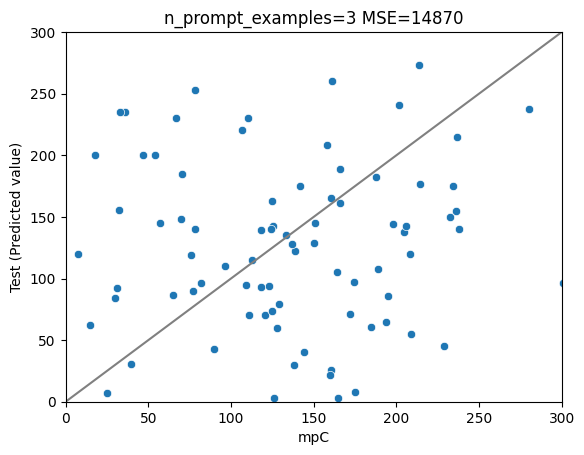

In [ ]:
#plot
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from datetime import datetime

current_datetime = datetime.now()
vmin=0
vmax=300

#plot prediction results
for n_prompt_examples,records in prediction_results.items():
    sel_df=pd.DataFrame(records)
    #floatに可能なものは変換
    sel_df["Test (Predicted value)"] = pd.to_numeric(sel_df["Test (Predicted value)"], errors='coerce')
    sel_df=sel_df[sel_df["Test (Predicted value)"].notnull()]
    if len(sel_df)==0:
        continue
    mse=mean_squared_error(sel_df["mpC"],sel_df["Test (Predicted value)"])

    plt.figure()
    sns.scatterplot(data=sel_df,x="mpC",y="Test (Predicted value)")
    plt.title(f"n_prompt_examples={n_prompt_examples} MSE={mse:.0f}")

    #x,yの範囲を揃える
    plt.xlim(vmin,vmax)
    plt.ylim(vmin,vmax)
    #対角線を描く
    plt.plot([vmin,vmax],[vmin,vmax],color="gray")
    formatted_filename = f"results/model={model_size}_{current_datetime.strftime('%Y%m%d_%H%M%S')}_train={do_train}.png"
    plt.savefig(formatted_filename)
    #break

In [ ]:
#スコア
mse